In [1]:
!cd /content/drive/MyDrive/daycon-movie

In [6]:
!unzip /content/drive/MyDrive/daycon-movie/movies-20210705T062821Z-001.zip

Archive:  /content/drive/MyDrive/daycon-movie/movies-20210705T062821Z-001.zip
  inflating: movies/submission.csv   
  inflating: movies/movies_test.csv  
  inflating: movies/movies_train.csv  


In [2]:
data_dir="/content/drive/MyDrive/daycon-movie/movies"

In [ ]:
# !pip install sklearn

In [149]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [150]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

In [184]:
#load data
train_data = pd.read_csv("movies/movies_train.csv")
test_data= pd.read_csv("movies/movies_test.csv")

In [ ]:
train_data.dtypes

In [185]:
#feature preprocessing
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []
    
    # 레이블 인코딩
    for f in features:
      if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
        cate_cols.append(f)
        le = LabelEncoder()
        # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
        le.fit(list(x_tr[f].values) + list(x_te[f].values))
        
        # train 데이터 레이블 인코딩 변환 수행
        x_tr[f] = le.transform(list(x_tr[f].values))
        
        # test 데이터 레이블 인코딩 변환 수행
        x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    # if do_imputing:
    #     # 중위값으로 결측치 채우기
    #     imputer = SimpleImputer(strategy='median')
    #     x_tr[features] = imputer.fit_transform(x_tr[features])
    #     x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

In [120]:
train_data['dir_prev_bfnum']=train_data['dir_prev_bfnum'].fillna(0) 

In [121]:
train_data.isnull().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [ ]:
from collections import Counter
sorted(Counter(train_data['director']).items(),key=lambda x:x[1])

In [188]:
#feature engineering
def feature_engineering1(df):
  #결측치 제거
  df['dir_prev_bfnum']=df['dir_prev_bfnum'].fillna(0) 

  #연월피처
  df['year_month']=df['release_time'].apply(lambda x:'-'.join(x.split('-')[:2]))

  #러닝타임 시간 관련 피처
  agg_func = ['mean','std','skew']
  agg_dict = {
      'time': agg_func,
      # 'num_staff': agg_func,
      # 'num_actor': agg_func
  }
  # dir_dict = {
      # 'time': agg_func,
      # 'num_staff': agg_func,
      # 'num_actor': agg_func
  # }
  
  # group by aggretation 함수로 train 데이터 피처 생성
  new_cols = []

  train_agg = df.groupby(['genre']).agg(agg_dict)
  for col in agg_dict.keys():
    for stat in agg_dict[col]:
        if type(stat) is str:
            new_cols.append(f'{col}-{stat}')
        else:
            new_cols.append(f'{col}-mode')

  train_agg.columns = new_cols
  train_agg.reset_index(inplace = True)
  
    
  df = df.merge(train_agg, on=['genre'], how='left')
  return df

In [97]:
#feature importance


In [174]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=3):
    
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    # skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)
    skf = KFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | RMSE: {mean_squared_error(y_val, val_preds)**0.5}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += mean_squared_error(y_val, val_preds)**0.5 / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean RMSE = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF RMSE = {mean_squared_error(y, y_oof)**0.5 }") # Out Of Fold Validation 스코어 출력
 
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    n=40
    color='blue'
    figsize=(12,8)
    
    fi = fi.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    fi['importance_normalized'] = fi['importance'] / fi['importance'].sum()
    fi['cumulative_importance'] = np.cumsum(fi['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    fi.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    plt.show()
    
    
    return y_oof, test_preds, fi

In [155]:
#model parameters
model_params = {
    'objective': 'regression', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'mse', # 평가 지표 설정
    'feature_fraction': 0.8, # 원래 0.8 피처 샘플링 비율
    'bagging_fraction': 0.8, # 원래 0.8 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,
}

In [ ]:
train_data['release_time']

In [189]:
# train, test, y, features = feature_engineering1(data)
drop_columns=['title','box_off_num']
y=train_data['box_off_num']
train_data=feature_engineering1(train_data)
test_data=feature_engineering1(test_data)
features=train_data.drop(columns=drop_columns).columns
train_data,test_data=feature_preprocessing(train_data,test_data,features)

train=train_data.drop(columns=["box_off_num"])



categorical feature: ['distributor', 'genre', 'release_time', 'screening_rat', 'director', 'year_month']


In [176]:
train_data.head(10)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year_month,time-mean,time-max,time-min,time-sum,time-skew
0,개들의 전쟁,97,10,163,96,3,517,0.00,0,91,2,23398,34,114.464286,153,83,3205,0.177466
1,내부자들,27,2,366,130,3,327,1161602.50,2,387,3,7072501,70,115.370370,180,75,3115,0.868821
2,은밀하게 위대하게,27,10,192,123,1,467,220775.25,4,343,4,6959083,41,114.464286,153,83,3205,0.177466
3,나는 공무원이다,7,11,141,101,2,26,23894.00,2,20,6,217866,30,105.264151,127,74,5579,-0.635643
4,불량남녀,122,11,44,108,1,282,1.00,1,251,2,483387,10,105.264151,127,74,5579,-0.635643
5,강철대오 : 구국의 철가방,97,11,159,113,1,337,837969.00,2,262,4,233211,33,105.264151,127,74,5579,-0.635643
6,길위에서,115,3,190,104,2,420,0.00,0,32,5,53526,40,88.053763,136,60,8189,0.640287
7,회사원,27,10,157,96,3,442,739522.00,3,342,2,1110523,33,114.464286,153,83,3205,0.177466
8,"1789, 바스티유의 연인들",162,6,284,129,2,490,0.00,0,3,5,4778,56,107.000000,133,80,535,0.184418
9,청춘그루브,13,4,122,94,1,254,0.00,0,138,3,868,26,104.651584,166,45,23128,0.044200


In [177]:
features

Index(['distributor', 'genre', 'release_time', 'time', 'screening_rat',
       'director', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'year_month', 'time-mean', 'time-max', 'time-min', 'time-sum',
       'time-skew'],
      dtype='object')

fold: 1, x_tr.shape: (400, 14), x_val.shape: (200, 14)
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[16]	training's l2: 2.1796e+12	valid_1's l2: 1.32787e+12
Fold 1 | RMSE: 1152331.664194713
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (400, 14), x_val.shape: (200, 14)
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 4.86111e+11	valid_1's l2: 1.9547e+12
Early stopping, best iteration is:
[132]	training's l2: 6.76786e+11	valid_1's l2: 1.89278e+12
Fold 2 | RMSE: 1375784.1424928322
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (400, 14), x_val.shape: (200, 14)
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	training's l2: 7.56699e+11	valid_1's l2: 2.81282e+12
Fold 3 | RMSE: 1677145.4102699694
----------------------------------------------

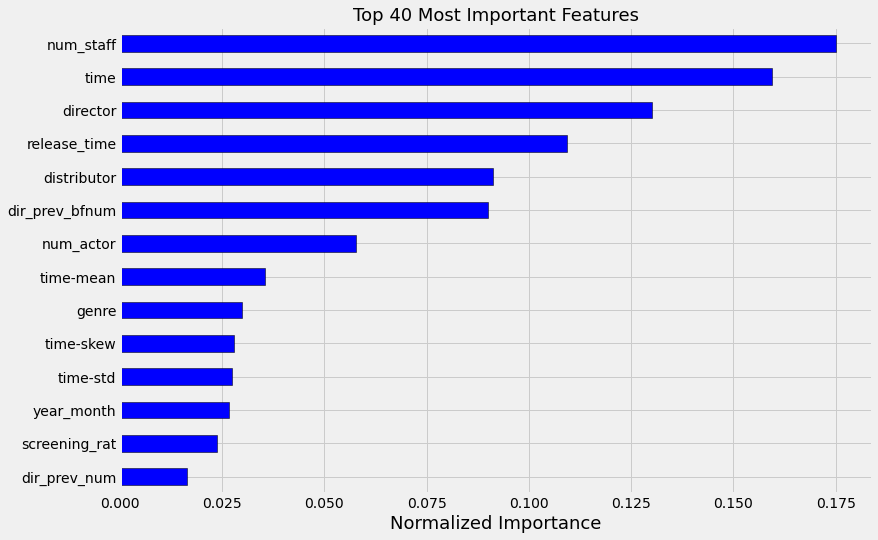

In [190]:
y_oof, test_preds, fi = make_lgb_oof_prediction(train_data, y, test_data, features, model_params=model_params)

In [191]:
submission= pd.read_csv("movies/submission.csv")
submission['box_off_num']=test_preds
submission['box_off_num']=submission['box_off_num'].apply(lambda x:x if x>0 else 0)

In [182]:
len(test_preds)

243

In [192]:
output_dir=f'/content/drive/MyDrive/daycon-movie/prediction'
os.makedirs(output_dir, exist_ok=True)

In [193]:
submission.to_csv(os.path.join(output_dir , 'output5.csv'), index=False)